# Visualization of country emissions using chorople maps and bubble charts

In [17]:
import pandas as pd
import numpy as np
import plotly.express as px
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

## Load full country dataset with clusters (notebook 03_)

In [18]:
data = pd.read_parquet('../data/FAOSTAT/clean_data/all_tables_processed/full_country_dataset_v4_TOTALS_with_clusters.parquet')
data.fillna(0, inplace=True)

print(f"Data shape: {data.shape}")
print(f"Nr. unique countries: {data['Area'].nunique()}")

Data shape: (8358, 9)
Nr. unique countries: 199


In [19]:
# country_codes = pd.read_csv('../data/FAOSTAT/clean_data/fao_country_codes_corrected.csv')
# country_codes.sample(5)

## Load world geometries.

### I need "iso_a3" codes to plot on map

In [20]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head(5)

/tmp/ipykernel_106921/4109974910.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


Countries unique to My Countries:
{'Cabo Verde', 'Serbia and Montenegro', 'Saint Lucia', 'R�union', 'Kiribati', 'Marshall Islands', 'Eswatini', 'Cook Islands', 'Monaco', 'Sao Tome and Principe', 'Saint Vincent and the Grenadines', 'Comoros', 'Antigua and Barbuda', 'Dominica', 'Bahrain', 'Maldives', 'French Polynesia', 'Mauritius', 'Nauru', 'Seychelles', 'Faroe Islands', 'Grenada', 'Barbados', 'Singapore', "côte d'ivoire", 'Saint Kitts and Nevis', 'Guadeloupe', 'Martinique', 'Samoa', 'Czechoslovakia', 'Tonga', 'Micronesia (Federated States of)', 'Malta'}

Countries unique to World Map Countries:
{'W. Sahara', 'N. Cyprus', 'Taiwan', 'Fr. S. Antarctic Lands', 'Falkland Is.', "Côte d'Ivoire", 'Kosovo', 'Antarctica', 'Greenland', 'eSwatini', 'Somaliland'}


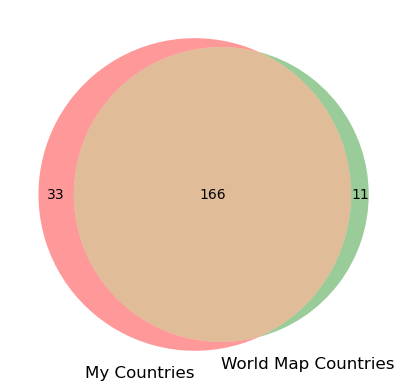

In [21]:
country_df = data.copy()

#Check intersection between country names
from matplotlib_venn import venn2

my_countries = set(country_df['Area'])
geo_countries = set(world['name'])

venn2([my_countries, geo_countries], set_labels = ('My Countries', 'World Map Countries'))

# List of countries unique to my_countries
unique_my_countries = my_countries - geo_countries

# List of countries unique to geo_countries
unique_geo_countries = geo_countries - my_countries

# Print the lists
print("Countries unique to My Countries:")
print(unique_my_countries)

print("\nCountries unique to World Map Countries:")
print(unique_geo_countries)


## Merge country dataset with geopandas nomenclature

In [22]:
# pd.set_option('display.max_rows', 100)
# country_df = pd.merge(country_df.drop('Area', axis=1), country_codes, how='left', on='Area Code')
# country_df[['Area Code', 'Area']].drop_duplicates().query('Area.isnull()').tail()

In [23]:
# #Impute manually only "china". Has several regions and names.
# #rest of missing country names are small islands, etc. I drop them for now.

# country_df['Area'] = np.where(country_df['Area Code'] == 351, 'China', country_df['Area'])
# country_df = country_df.dropna(subset=['Area'])

## Choropleth year 2021

In [24]:
# Define dummy target emissions column. After cleaning dataset, you can replace this with actual emissions data
target = 'Agrifood_systems_Emissions_(CO2eq)_(AR5)_kt'
year = 2021

In [25]:
df_2021 = country_df[country_df['Year'] == year][['Area', target]].dropna()
df_2021 = df_2021.groupby('Area').sum().reset_index()

In [26]:
# Merge the data with the world GeoDataFrame
world = world.merge(df_2021, how='left', left_on='name', right_on='Area').dropna()

### Map by country - total value

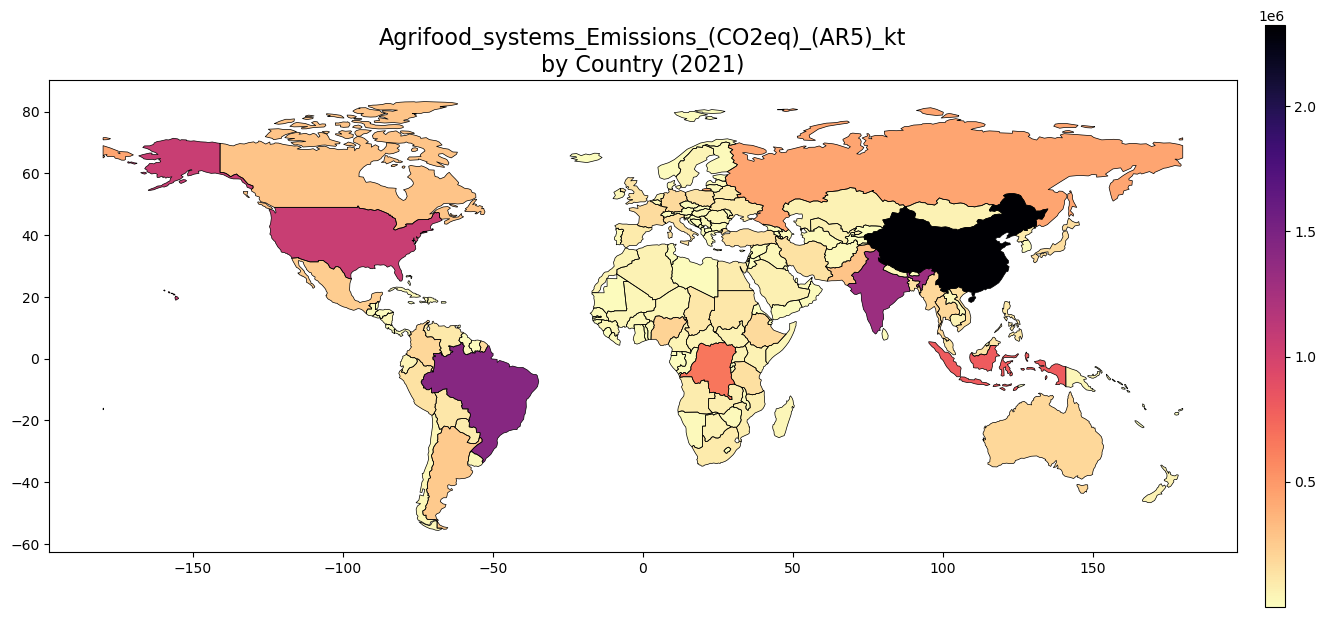

In [27]:
# Get the reversed magma color palette from Seaborn, same as for treemap plots
magma_palette_reversed = sns.color_palette("magma_r", as_cmap=True)

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Plot with custom legend parameters
plot = world.plot(column=target, ax=ax, legend=True,
                  legend_kwds={'orientation': "vertical",
                               'shrink': 0.6,  # Make colorbar smaller
                               'aspect': 30,   # Make colorbar thinner
                               'pad': 0.02},   # Adjust padding
                  cmap=magma_palette_reversed)

plt.title(f"{target}\nby Country ({year})", fontsize=16)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.savefig(f"../plots/{target}_TOTAL_map.png")
plt.savefig(f"../plots/{target}_TOTAL_map.pdf")

plt.show()

### Map by country - per capita emissions

In [28]:
world[target] = world[target] / world['pop_est']  # per capita emissions

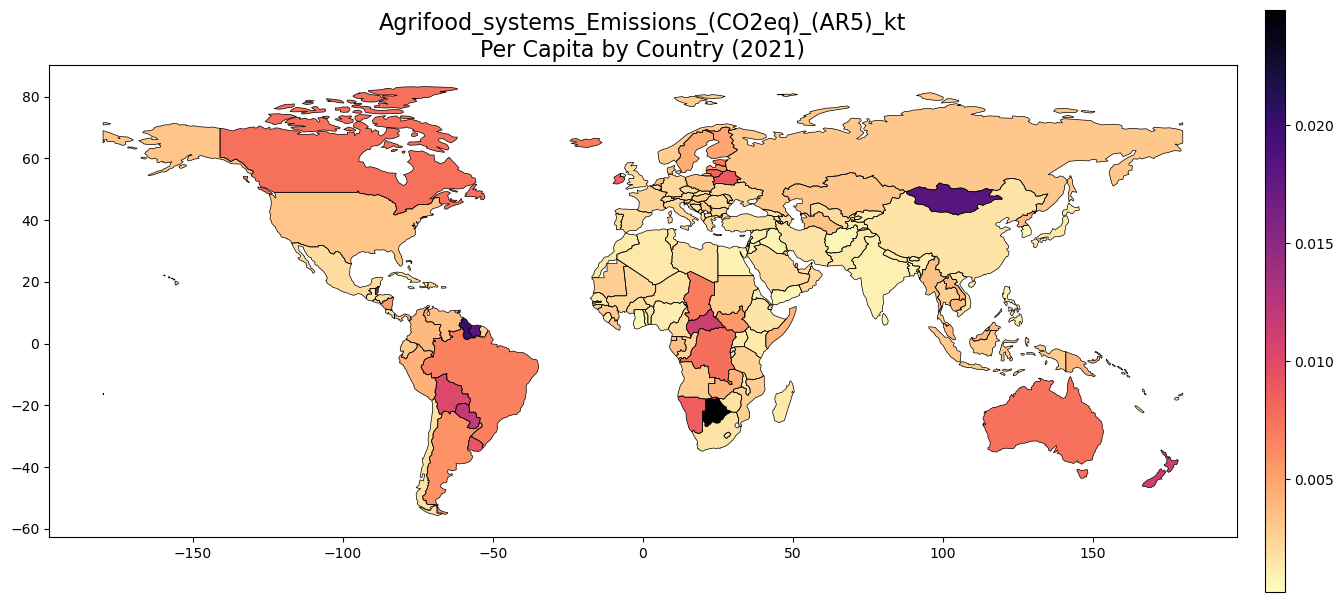

In [29]:
# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Plot with custom legend parameters
plot = world.plot(column=target, ax=ax, legend=True,
                  legend_kwds={'orientation': "vertical",
                               'shrink': 0.6,  # Make colorbar smaller
                               'aspect': 30,   # Make colorbar thinner
                               'pad': 0.02},   # Adjust padding
                  cmap=magma_palette_reversed)

plt.title(f"{target}\nPer Capita by Country ({year})", fontsize=16)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.savefig(f"../plots/{target}_percapita_map.png")
plt.show()

# Interactive map with plotly express

In [30]:
df = country_df[['Year', 'Area', target]].dropna()
df = df.groupby(['Year', 'Area']).sum().reset_index()

# Merge the data with the world GeoDataFrame
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_full = world.merge(df, how='left', left_on='name', right_on='Area').dropna()

/tmp/ipykernel_106921/4220431971.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


### Total emissions by country over time

In [31]:
# Get the reversed magma color palette from Seaborn
magma_palette_reversed = sns.color_palette("magma_r", n_colors=256)

# Convert the Seaborn color palette to a format Plotly can use
magma_plotly = [f'rgb({int(r*255)},{int(g*255)},{int(b*255)})' for r, g, b in magma_palette_reversed]

# Calculate global min and max
vmin = world_full[target].min()
vmax = world_full[target].max()

# Plot the interactive choropleth map
fig = px.choropleth(
    world_full, 
    locations='iso_a3', 
    locationmode='ISO-3', 
    color=target, 
    hover_name='iso_a3', 
    animation_frame='Year',
    color_continuous_scale=magma_plotly,  # Use the custom color scale
    range_color=(vmin, vmax)  # Set the range of the color scale
)

fig.update_layout(
    width=1000,
    height=600,
    title={
        'text': f'{target}<br>by Country Over the Years',
        'x': 0.5,
        'xanchor': 'center'
    },
    coloraxis_colorbar=dict(
        title=""
    )
)

fig.write_html(f"../plots/{target}_TOTAL_map.html")
fig.show()

### Per capita emissions by country over time

In [32]:
world_full[target] = world_full[target] / world_full['pop_est']  # per capita emissions

In [33]:
# Get the reversed magma color palette from Seaborn
magma_palette_reversed = sns.color_palette("magma_r", n_colors=256)

# Convert the Seaborn color palette to a format Plotly can use
magma_plotly = [f'rgb({int(r*255)},{int(g*255)},{int(b*255)})' for r, g, b in magma_palette_reversed]

# Calculate global min and max
vmin = world_full[target].min()
vmax = world_full[target].max()

# Plot the interactive choropleth map
fig = px.choropleth(
    world_full, 
    locations='iso_a3', 
    locationmode='ISO-3', 
    color=target, 
    hover_name='iso_a3', 
    animation_frame='Year',
    color_continuous_scale=magma_plotly,  # Use the custom color scale
    range_color=(vmin, vmax)  # Set the range of the color scale
)

fig.update_layout(
    width=1000,
    height=600,
    title={
        'text': f'{target}<br>Per Capita by Country Over the Years',
        'x': 0.5,
        'xanchor': 'center'
    },
    coloraxis_colorbar=dict(
        title=""
    )
)

fig.write_html(f"../plots/{target}_percapita_map.html")
fig.show()

## Save to chart studio

In [34]:
# import chart_studio 

# username = "ezemriv"
# password = "dmanBuRgSIAPjUFi4m1X"

# chart_studio.tools.set_credentials_file(username=username, api_key=password)

# import chart_studio.plotly as py
# import chart_studio.tools as tls

In [35]:
# py.plot(fig, filename = f'{target}_per_capita', auto_open=False)

# Map colored by clusters

Same but target should be "Clusters" column

/tmp/ipykernel_106921/4154852579.py:2: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



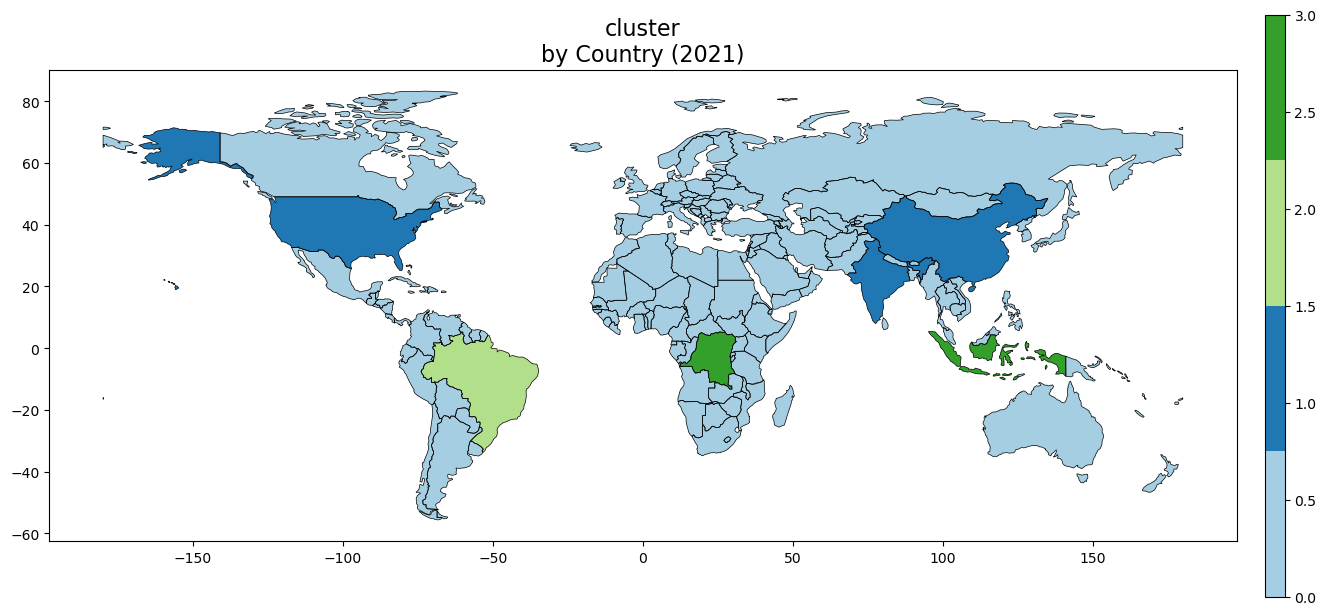

In [36]:
country_df = data.copy()
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

target = 'cluster'
year = 2021

df_2021 = country_df[country_df['Year'] == year][['Area', target]].dropna()
df_2021 = df_2021.groupby('Area').sum().reset_index()

# Merge the data with the world GeoDataFrame
world = world.merge(df_2021, how='left', left_on='name', right_on='Area').dropna()

# Get the reversed magma color palette from Seaborn, same as for treemap plots
n_clusters = world[target].nunique()
magma_palette_reversed = sns.color_palette("Paired", n_colors=n_clusters)
discrete_cmap = ListedColormap(magma_palette_reversed)


# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Plot with custom legend parameters
plot = world.plot(column=target, ax=ax, legend=True,
                  legend_kwds={'orientation': "vertical",
                               'shrink': 0.6,  # Make colorbar smaller
                               'aspect': 30,   # Make colorbar thinner
                               'pad': 0.02},   # Adjust padding
                  cmap=discrete_cmap)

plt.title(f"{target}\nby Country ({year})", fontsize=16)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.savefig(f"../plots/{target}_TOTAL_map.png")
plt.savefig(f"../plots/{target}_TOTAL_map.pdf")

plt.show()